In [1]:
def reduce_mem_usage_colwise(col):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    col_type = col.dtypes
    if col_type in numerics:
        c_min = col.min()
        c_max = col.max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                col = col.astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                col = col.astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                col = col.astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                col = col.astype(np.int64)  
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                col = col.astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                col = col.astype(np.float32)
            else:
                col = col.astype(np.float64)       
    return col

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import multiprocessing as mp
from functools import partial
import gc
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
%%time
DATA_PATH = 'Data/'
OUTPUT_PATH = 'Output/'

oof_prev = pd.read_csv(OUTPUT_PATH + 'oofs_lgbm.csv')
preds_prev = pd.read_excel(OUTPUT_PATH + 'preds_lgbm.xlsx')

train = pd.read_csv(DATA_PATH + 'train_data.csv')
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_sub = pd.read_csv(DATA_PATH + 'Sample Submission.csv')

CPU times: user 19 s, sys: 2.16 s, total: 21.2 s
Wall time: 21.6 s


In [4]:
train = pd.merge(train, train_labels, on = 'patient_id', how='left')
df = pd.concat([train, test])
df = df.drop_duplicates()
comp_train = train_labels.copy()
comp_test = sample_sub.copy()

In [5]:
df['made_payment'] = pd.qcut(df['patient_payment'], 400, duplicates='drop', labels=False).astype('str')

In [6]:
%%time
for c in ['event_name', 'plan_type', 'specialty', 'made_payment']:
    recency = df.groupby(c).apply(lambda x: x.groupby('patient_id')['event_time'].min()).unstack().T.reset_index()
    recency.columns = [col + '_' + c if col != 'patient_id' else 'patient_id' for col in recency.columns]
    comp_train = pd.merge(comp_train, recency, on = 'patient_id', how='left')
    comp_test = pd.merge(comp_test, recency, on = 'patient_id', how='left')

CPU times: user 29 s, sys: 2.64 s, total: 31.6 s
Wall time: 31.6 s


In [7]:
comp_train['prev_preds'] = oof_prev['outcome_flag']
comp_test['prev_preds'] = preds_prev['outcome_flag']

In [8]:
comp_train = comp_train.apply(lambda x: reduce_mem_usage_colwise(x))
comp_test = comp_test.apply(lambda x: reduce_mem_usage_colwise(x))

In [9]:
del train, test, df, recency, oof_prev, preds_prev, train_labels, sample_sub
gc.collect()

14350

In [10]:
ID_COL, TARGET_COL = 'patient_id', 'outcome_flag'
features = [c for c in comp_train if c not in [ID_COL, TARGET_COL]]
target = comp_train[TARGET_COL]
features = comp_train[features].isnull().sum().sort_values(ascending=False)[420:].index.tolist()
print(len(features))
to_drop_cols = [c for c in comp_train.columns if c not in features]
to_drop_cols.remove(ID_COL)
comp_train.drop(to_drop_cols, axis=1, inplace=True)
comp_test.drop(to_drop_cols, axis=1, inplace=True)
comp_train.shape[1]

438


439

In [11]:
gc.collect()

0

In [12]:
param = {'num_leaves': 5000,
         'min_data_in_leaf': 220, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.22,
         "metric": 'auc',
         "lambda_l1": 2,
         "lambda_l2": 0.6,
         "random_state": 6,
         "verbosity": -1,
         'scale_pos_weight': 1.15}

In [13]:
max_iter = 10
folds = StratifiedKFold(n_splits=max_iter, random_state=1991)
oof = np.zeros(len(comp_train))
categorical_columns = None
predictions_test = np.zeros(len(comp_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(comp_train.values, target)):
    print("fold n°{}".format(fold_))
    X_trn, y_trn = comp_train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_val, y_val = comp_train.iloc[val_idx][features], target.iloc[val_idx]
    X_comp_test = comp_test[features]
    trn_data = lgb.Dataset(X_trn, y_trn, categorical_feature = categorical_columns)
    val_data = lgb.Dataset(X_val, y_val, categorical_feature = categorical_columns)
    num_round = 500000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=400, early_stopping_rounds = 800)
    oof[val_idx] = clf.predict(X_val, num_iteration=clf.best_iteration)
    
    del trn_data, val_data, X_trn, X_val, y_trn, y_val
    gc.collect()
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    current_comp_test_pred = clf.predict(X_comp_test, num_iteration=clf.best_iteration)
    predictions_test += current_comp_test_pred / folds.n_splits
    
    del X_comp_test, current_comp_test_pred, clf
    
    gc.collect()
  
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold n°0
Training until validation scores don't improve for 800 rounds
[400]	training's auc: 0.911273	valid_1's auc: 0.83652
[800]	training's auc: 0.940299	valid_1's auc: 0.848034
[1200]	training's auc: 0.962182	valid_1's auc: 0.856011
[1600]	training's auc: 0.977676	valid_1's auc: 0.862563
[2000]	training's auc: 0.987575	valid_1's auc: 0.866877
[2400]	training's auc: 0.993572	valid_1's auc: 0.869715
[2800]	training's auc: 0.996896	valid_1's auc: 0.870827
[3200]	training's auc: 0.99862	valid_1's auc: 0.871773
[3600]	training's auc: 0.999428	valid_1's auc: 0.872317
[4000]	training's auc: 0.999776	valid_1's auc: 0.872346
[4400]	training's auc: 0.999921	valid_1's auc: 0.872079
Early stopping, best iteration is:
[3968]	training's auc: 0.999758	valid_1's auc: 0.872546
fold n°1
Training until validation scores don't improve for 800 rounds
[400]	training's auc: 0.911843	valid_1's auc: 0.848174
[800]	training's auc: 0.941108	valid_1's auc: 0.855254
[1200]	training's auc: 0.962534	valid_1's auc

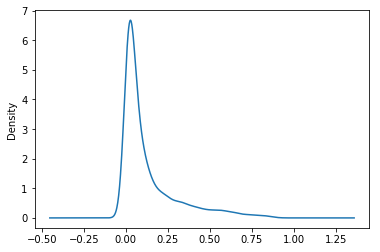

In [14]:
pd.Series(predictions_test).plot(kind='density')

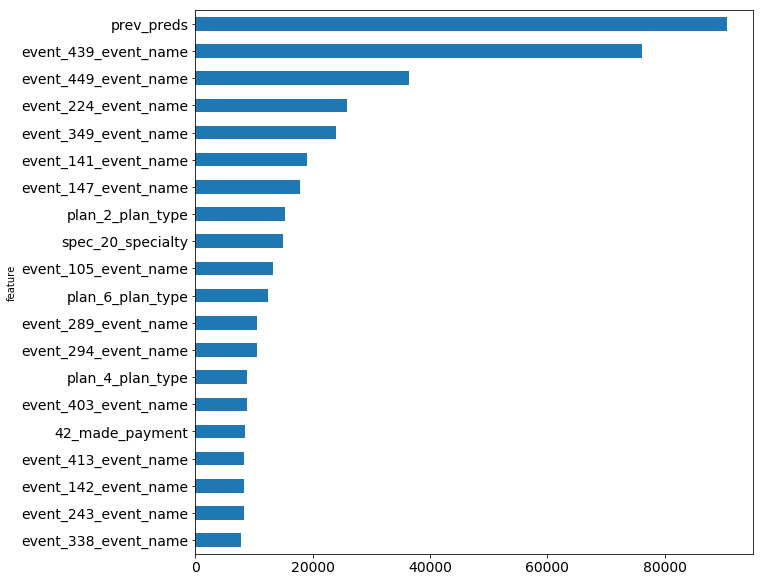

In [15]:
fi = feature_importance_df.groupby('feature')['importance'].mean().sort_values()
plt.figure(figsize=(10,10))
fi[-20:].plot.barh(fontsize=14)

In [16]:
oof_df = pd.DataFrame()
oof_df['patient_id'] = comp_train['patient_id']
oof_df[TARGET_COL] = oof
oof_df.to_csv(OUTPUT_PATH + 'oof_lgbm_2.csv', index=False)

In [17]:
sub_df = pd.DataFrame()
sub_df[ID_COL] = comp_test[ID_COL]
sub_df[TARGET_COL] = predictions_test
sub_df[[TARGET_COL]].to_excel(OUTPUT_PATH + 'preds_lgbm_2.xlsx', index=False)
sub_df.head(10)

,patient_id,outcome_flag
0,patient_2,0.065886
1,patient_3,0.187469
2,patient_5,0.559389
3,patient_8,0.006929
4,patient_14,0.449431
5,patient_15,0.080379
6,patient_16,0.015987
7,patient_33,0.226737
8,patient_38,0.012341
9,patient_41,0.068882
